In [1]:
%matplotlib inline
from dataclasses import dataclass
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import rosbag
import scipy.optimize
from angles import shortest_angular_distance
from ruvu_odometry_calibration.odometry_calibration import to_matrix, pairs, inverse_odometry, odometry
from ruvu_odometry_calibration.tf2_rosbag import BagBuffer
from tf.transformations import inverse_matrix, translation_from_matrix, \
    euler_from_matrix, identity_matrix
from tf2_ros import ExtrapolationException

# bag_file_path = '/home/ramon/2021-02-26-13-55-27_filtered.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-40-17_error.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-29-35_tuned.bag'
# bag_file_path = '/home/ramon/2021-03-05-13-43-38_linear_error.bag'
bag_file_path = '/home/ramon/2021-03-05-14-30-29_angle_error.bag'

bag = rosbag.Bag(bag_file_path)
bag_transformer = BagBuffer(bag)

/home/ramon/ros/movigo/src/odometry_calibration/ruvu_odometry_calibration/src/ruvu_odometry_calibration/tf2_rosbag.py:15: UserWarning: translation should be of type Vector3
  self.set_transform(tf, 'rosbag')
/home/ramon/ros/movigo/src/odometry_calibration/ruvu_odometry_calibration/src/ruvu_odometry_calibration/tf2_rosbag.py:15: UserWarning: rotation should be of type Quaternion
  self.set_transform(tf, 'rosbag')


In [2]:
@dataclass
class DataPoint:
    timestamp: Any
    ground_truth: Any
    measurement: Any


data = []
for _, msg, _ in bag.read_messages(topics=['/scan']):
    try:
        ground_truth = bag_transformer.lookup_transform('map', 'base_link', msg.header.stamp)
        measurement = bag_transformer.lookup_transform('odom', 'base_link', msg.header.stamp)
    except ExtrapolationException:
        continue
    ground_truth = to_matrix(ground_truth)
    measurement = to_matrix(measurement)
    data.append(DataPoint(timestamp=msg.header.stamp, ground_truth=ground_truth, measurement=measurement))

print(len(data), 'data points')
newdata = [data[0]]
for d in data:
    if np.linalg.norm(translation_from_matrix(d.measurement) - translation_from_matrix(newdata[-1].measurement)) > 0.1:
        newdata.append(d)
data = newdata
# data = data[::5]
print(len(data), 'data points')

594 data points
129 data points


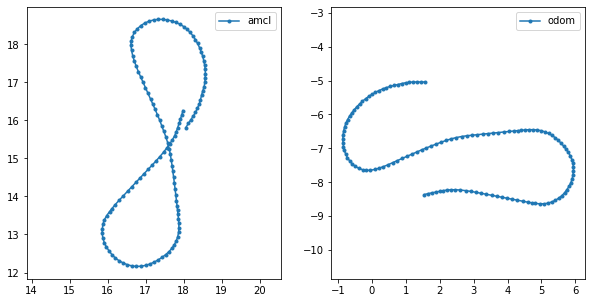

In [3]:
ground_truth = np.array([translation_from_matrix(d.ground_truth) for d in data])
measurement = np.array([translation_from_matrix(d.measurement) for d in data])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(ground_truth[:, 0], ground_truth[:, 1], '.-', label='amcl')
ax.legend();
ax.axis('equal')

ax = fig.add_subplot(1, 2, 2)
ax.plot(measurement[:, 0], measurement[:, 1], '.-', label='odom');
ax.legend();
ax.axis('equal');

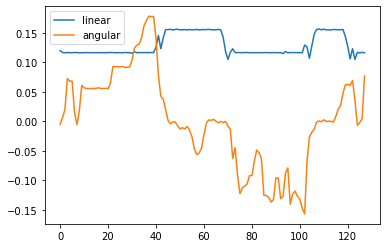

In [4]:
commands = []

for d1, d2 in pairs(data):
    linear, angular = inverse_odometry(d1.measurement, d2.measurement)
    commands.append((linear, angular))

commands = np.array(commands)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(commands[:, 0], label='linear')
ax.plot(commands[:, 1], label='angular')
ax.legend();

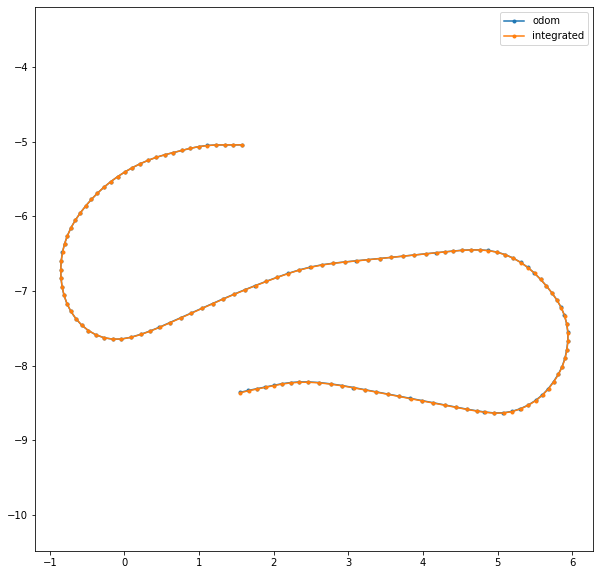

In [5]:
measurements = np.array([translation_from_matrix(d.measurement) for d in data])

positions = [data[0].measurement]
for d1, d2 in pairs(data):
    linear, angular = inverse_odometry(d1.measurement, d2.measurement)
    positions.append(odometry(positions[-1], linear, angular))
positions = np.array([translation_from_matrix(p) for p in positions])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(measurements[:, 0], measurements[:, 1], '.-', label='odom')
ax.plot(positions[:, 0], positions[:, 1], '.-', label='integrated')
ax.legend()
ax.axis('equal');

err: 0.1729831398782226 1.0 1.0
err: 0.17298314950347757 1.0000000149011612 1.0
err: 0.17298312821896125 1.0 1.0000000149011612
err: 0.12084520818343154 0.9072258867889686 1.0192683789356345
err: 0.12084520992857532 0.9072259016901298 1.0192683789356345
err: 0.12084520886042395 0.9072258867889686 1.019268394123917
err: 0.11956000539567718 0.8892731870350749 1.0112869035250898
err: 0.11956000543980298 0.889273201936236 1.0112869035250898
err: 0.11956000543550756 0.8892731870350749 1.0112869185944389
err: 0.11955885449746947 0.8887537256062569 1.0109984429289678
err: 0.11955885449746004 0.8887537405074181 1.0109984429289678
err: 0.11955885449752003 0.8887537256062569 1.0109984579940186
err: 0.1195588544972248 0.8887536668000791 1.0109983032619685
err: 0.11955885449723172 0.8887536817012403 1.0109983032619685
err: 0.11955885449723427 0.8887536668000791 1.0109983183270173
err: 0.1729831398782226 1 1
err: 0.1195588544972248 0.8887536668000791 1.0109983032619685


(-0.03294339527693458, 0.03349940891848042)

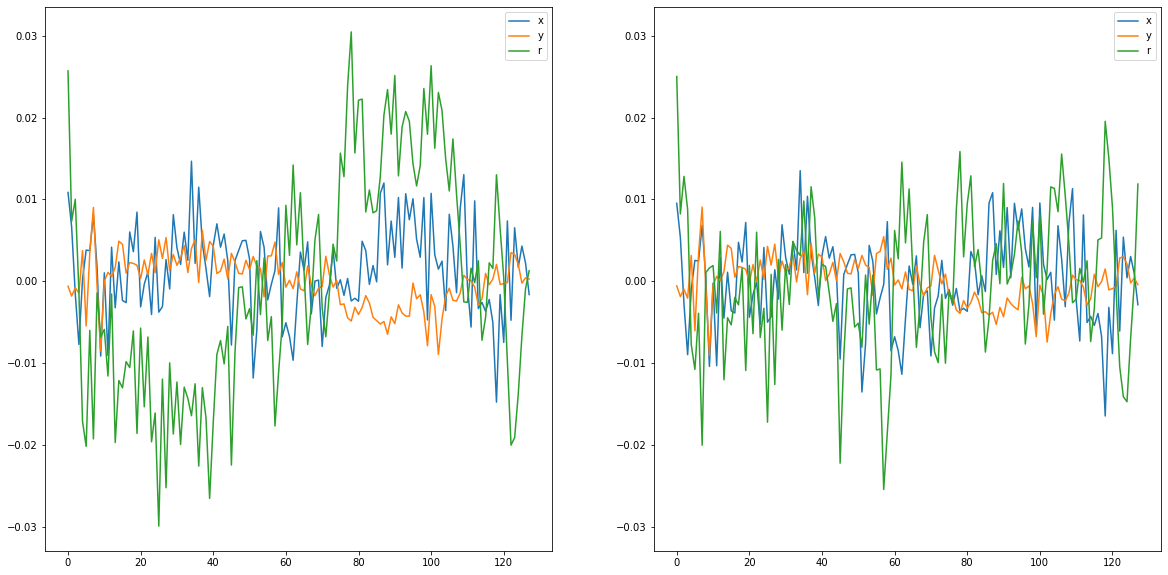

In [6]:
def f(x):
    errs = []
    for d1, d2 in pairs(data):
        linear, angular = inverse_odometry(d1.measurement, d2.measurement)

        # model parameters
        wheel_separation_multiplier = x[0]
        wheel_radius_multiplier = x[1]

        linear2 = linear * wheel_radius_multiplier
        angular2 = angular * wheel_radius_multiplier / wheel_separation_multiplier

        new_pos = odometry(identity_matrix(), linear2, angular2)

        # x and y error
        delta_ground_truth = np.dot(inverse_matrix(d1.ground_truth), d2.ground_truth)
        err_2d = translation_from_matrix(delta_ground_truth)[:2] - translation_from_matrix(new_pos)[:2]

        # rotation error
        err_rot = shortest_angular_distance(euler_from_matrix(delta_ground_truth)[2], euler_from_matrix(new_pos)[2])
        errs.append((err_2d[0], err_2d[1], err_rot))

    errs = np.array(errs)
    print('err:', np.linalg.norm(errs), x[0], x[1])
    return errs


bounds = (0.5, 2)
result = scipy.optimize.least_squares(lambda x: np.ndarray.flatten(f(x)), [1, 1], bounds=list(zip(bounds, bounds)))


fig = plt.figure(figsize=(20, 10))

original = f((1, 1))
ax = fig.add_subplot(1, 2, 1)
ax.plot(original[:, 0], label='x')
ax.plot(original[:, 1], label='y')
ax.plot(original[:, 2], label='r')
ax.legend();
ylim = ax.get_ylim()

corrected = f(result.x)
ax = fig.add_subplot(1, 2, 2)
ax.plot(corrected[:, 0], label='x')
ax.plot(corrected[:, 1], label='y')
ax.plot(corrected[:, 2], label='r')
ax.legend();
ax.set_ylim(ylim)


In [7]:
del result['fun']
del result['jac']
print(result)
print('wheel_separation_multiplier', result.x[0])
print('wheel_radius_multiplier', result.x[1])

 active_mask: array([0, 0])
        cost: 0.007147159844344285
        grad: array([4.58176950e-08, 5.10471452e-08])
     message: '`ftol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 2.608500459902767e-08
      status: 2
     success: True
           x: array([0.88875367, 1.0109983 ])
wheel_separation_multiplier 0.8887536668000791
wheel_radius_multiplier 1.0109983032619685
